In [1]:
import numpy as np

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

**Answer to Question 1:**

In [10]:
from scipy import optimize
from scipy import interpolate

In [11]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def disutility(gamma, l):
    return gamma*l

def v2(c2, l2, rho, gamma):
    if l2 == 0: 
        c = b
    elif l2 == 1:
        c = w * h2 
    return utility(c2,rho) - disutility(gamma, l2)

def v1(c1, l1, rho, gamma, beta, w, h1, Delta, v2_interp):
    
    # a. v2 value, if l = 0
    h2_low = h1
    c2_low = b
    v2_low = v2_interp([h2_low, c2_low])[0]
    
    # b. v2 value, if l
    h2_high = h1 + l1 + Delta
    c2_high = w * h2
    v2_high = v2_interp([h2_high, c2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

In [30]:
def solve_period_2(rho, l2, gamma, Delta):

    # a. grids
    h2_vec = np.linspace(0.1, 1.5, 100) 
    v2_vec = np.empty(100)
    c2_vec = np.empty(100)

    # b. solve for each m2 in grid
    for i, h2 in enumerate(h2_vec):

        # i. objective
        obj = lambda c2: -v2(c2, l2, rho, gamma)

        # ii. initial value (consume half)
        x0 = h2/2

        # iii. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,h2])

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return h2_vec,v2_vec,c2_vec

In [33]:
def solve_period_1(rho, gamma, beta, w, Delta, v1, v2_interp):

    # a. grids
    h1_vec = np.linspace(0.1,1.5,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,h1 in enumerate(h1_vec):
        
        # i. objective
        obj = lambda c1: -v1(c1, l1, rho, gamma, beta, w, h1, Delta, v2_interp)
        
        # ii. initial guess (consume half)
        x0 = h1/2
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,h1])
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
     
    return h1_vec,v1_vec,c1_vec

In [35]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1
l2 = 0
l1 = 1

def solve(rho, gamma, w, beta, Delta, v1):
    
    # a. solve period 2
    h2_vec,v2_vec,c2_vec = solve_period_2(rho, l2, gamma, Delta)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator((h2_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)
    
    # b. solve period 1
    h1_vec,v1_vec,c1_vec = solve_period_1(rho, gamma, beta, w, Delta, v1, v2_interp)
    
    return h1_vec,c1_vec

h1_vec,c1_vec = solve(rho, gamma, w, beta, Delta,v1)

NameError: name 'h2' is not defined

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [35]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Answer to question 1:**

In [3]:
import sympy as sm
sm.init_printing(use_unicode=True)

h = sm.symbols('h')
alpha = sm.symbols('alpha')
v = sm.symbols('v_t')
b = sm.symbols('b')
y_t = sm.symbols('y_t')  
pi_t = sm.symbols('pi_t') 

pi_t_1 = sm.symbols('\pi_{t-1}')
gamma = sm.symbols('gamma')
phi = sm.symbols('\phi')
y_t_1 = sm.symbols('y_{t-1}')
s_t = sm.symbols('s_t')
s_t_1 = sm.symbols('s_{t-1}')

 
h, alpha, v, b, y_t, pi_t, pi_t_1, gamma, phi, y_t_1, s_t, s_t_1

In [4]:
AD = sm.Eq((1/(h*alpha))*(v - (1+b*alpha)*y_t), pi_t)
SRAS = sm.Eq((pi_t_1 + gamma*y_t - phi*gamma*y_t_1 + s_t - phi*s_t_1), pi_t)
AD, SRAS

**Solving for the equilibrium value of output ($y_{t}$)**

In [5]:
AD_1 = sm.solve(AD, pi_t)
AD_1

In [6]:
AD_2 = SRAS.subs(pi_t, AD_1[0])
AD_2

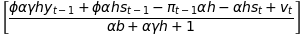

In [7]:
Output = sm.solve(AD_2, y_t)
Output

**Solving for the equilibrium value of inflation ($\pi_{t}$)**

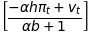

In [26]:
AD_3 = sm.solve(AD,y_t)
AD_3

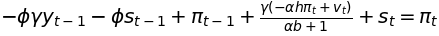

In [28]:
AD_4 = SRAS.subs(y_t, AD_3[0])
AD_4

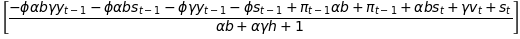

In [29]:
Inflation = sm.solve(AD_4, pi_t)
Inflation

**Answer to Question 2:**

In [31]:
sol_output = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b), Output[0])
def _sol_output(y_t_1, s_t_1, pi_t_1, s_t, v, phi=par['phi'], alpha=par['alpha'], gamma=par['gamma'], h=par['h'], b=par['b']):
    return sol_output(y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b)

C = _sol_output(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
D = _sol_output(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)
C,D

In [36]:
Infl = sm.Eq(pi_t,((alpha*b + 1)*(-phi*gamma*y_t_1 - phi*s_t_1 + pi_t_1 + s_t) + gamma*v)/(alpha*b + alpha*gamma +1))
Infl1 = sm.solve(Infl, pi_t_1)
Infl2 = Output.subs(pi_t_1, Infl1)
Infl2

AttributeError: 'list' object has no attribute 'subs'

In [18]:
sol = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, gamma, alpha, b, phi), Infl1[0])
def solution(y_t_1, s_t_1, pi_t_1, s_t, v, gamma=par['gamma'], alpha=par['alpha'], b=par['b'], phi=par['phi']):
    return sol(y_t_1, s_t_1, pi_t_1, s_t, v, gamma, alpha, b, phi)

B = sol(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
A = sol(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)
A,B

TypeError: _lambdifygenerated() got an unexpected keyword argument 'y_t_1'

In [34]:
sol_inflation = sm.lambdify((y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b), Inflation[0])
def _sol_inflation(y_t_1, s_t_1, pi_t_1, s_t, v, phi=par['phi'], alpha=par['alpha'], gamma=['gamma'], h=par['h'], b=par['b']):
    return sol_inflation(y_t_1, s_t_1, pi_t_1, s_t, v, phi, alpha, gamma, h, b)

B = _sol_inflation(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0)
A = _sol_inflation(y_t_1=0, s_t_1=0, pi_t_1=0, s_t=0, v=0.1)
A,B

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x = [B,A]
y = [C,D]
ax.plot(x,y)

ax.set_xlim([0,0.002])
ax.set_ylim([0,0.03])

plt.show()

NameError: name 'B' is not defined

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [ ]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [ ]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [ ]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

In [ ]:
def find_demand_good_1(alphas,p1,p2,k):
    dist = demand_good_1_func(alphas,p1,p2,k)
    total = dist.sum()
    return dist,total

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?